In [27]:
import sys
sys.path.append('../src')  # Add the src directory

from utils.file_handler import BetfairFileHandler
from models import GRUModel, LSTMModel, TransformerModel, BiLSTMModel, train_model, plot_loss_curves, prepare_dataloaders
from models.model_utils import save_model, load_model, process_multiple_markets, normalize_data
from preprocessing.feature_engineering import calculate_macd, calculate_roc, calculate_moving_average
from preprocessing.data_preprocessor import preprocess_market_data, drop_na_rows, remove_outliers
from models.evaluation import plot_predictions, plot_residuals, plot_residual_histogram

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import betfairutil
import seaborn as sns
import os
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
ROOT_DIR = "/Users/charaka/Desktop/Projects/football-lstm-betting"

In [3]:
input_directory = os.path.join(ROOT_DIR, "data/raw/files/")
output_directory = os.path.join(ROOT_DIR, "data/processed/")

# handler = BetfairFileHandler()
# handler.extract_files(input_directory, output_directory, should_restrict_to_inplay=True, _format=betfairutil.DataFrameFormatEnum.LAST_PRICE_TRADED)

In [6]:
input_directory, output_directory

('/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/files/',
 '/Users/charaka/Desktop/Projects/football-lstm-betting/data/processed/')

## Load Model Data 

In [4]:
market_dfs = []

for file in os.listdir(output_directory):
    if file.endswith('.csv'):
        data_path = os.path.join(output_directory, file)
        df = pd.read_csv(data_path)[["market_id", "selection_id", "last_price_traded", "publish_time"]]
        market_dfs.append(df)

X_train, y_train, X_val, y_val, X_test, y_test = process_multiple_markets(market_dfs)

X_train.shape, y_train.shape

((133996, 10, 15), (133996, 3))

In [11]:
from sklearn.model_selection import train_test_split

# def process_multiple_markets(dfs, sequence_length=10, val_ratio=0.15, test_ratio=0.1):
#     """
#     Process multiple market dataframes to create train, validation, and test sequences and labels for LSTM training.
    
#     Parameters:
#     - dfs: List of DataFrames, each containing data for a different market.
#     - sequence_length: Number of intervals to consider for each sequence.
#     - val_ratio: Proportion of data to be used for validation.
#     - test_ratio: Proportion of data to be used for testing.
    
#     Returns:
#     - Train, validation, and test sequences and labels.
#     """
    
#     train_sequences, val_sequences, test_sequences = [], [], []
#     train_labels, val_labels, test_labels = [], [], []
    
#     # Process each dataframe individually
#     for df in dfs:
#         processed_df = preprocess_market_data(df)
#         processed_cleaned_df = drop_na_rows(processed_df)

#         # Calculate synthetic features
#         roc = calculate_roc(processed_cleaned_df)
#         ma = calculate_moving_average(processed_cleaned_df)
#         macd, signal = calculate_macd(processed_cleaned_df)
#         processed_cleaned_df = remove_outliers(processed_cleaned_df)

#         # Combine the features into a single dataframe
#         features_df = pd.concat([processed_cleaned_df, roc.add_suffix('_roc'), ma.add_suffix('_ma'), macd.add_suffix('_macd'), signal.add_suffix('_signal')], axis=1)
#         features_df = drop_na_rows(features_df)
        
#         sequences, labels = create_sequences(features_df, sequence_length)

#         # Train-Val-Test split for the current market
#         # First, separate out the test set
#         sequences_train_val, sequences_test, labels_train_val, labels_test = train_test_split(sequences, labels, test_size=test_ratio, shuffle=False)
        
#         # Now, split the remaining data into train and validation sets
#         sequences_train, sequences_val, labels_train, labels_val = train_test_split(sequences_train_val, labels_train_val, test_size=val_ratio / (1 - test_ratio), shuffle=False)
        
#         train_sequences.append(sequences_train)
#         val_sequences.append(sequences_val)
#         test_sequences.append(sequences_test)
#         train_labels.append(labels_train)
#         val_labels.append(labels_val)
#         test_labels.append(labels_test)
    
#     # Concatenate sequences and labels from all dataframes
#     X_train = np.concatenate(train_sequences, axis=0)
#     y_train = np.concatenate(train_labels, axis=0)
#     X_val = np.concatenate(val_sequences, axis=0)
#     y_val = np.concatenate(val_labels, axis=0)
#     X_test = np.concatenate(test_sequences, axis=0)
#     y_test = np.concatenate(test_labels, axis=0)
    
#     return X_train, y_train, X_val, y_val, X_test, y_test


# Use the function to process both provided dataframes
market_dfs = []

for file in os.listdir(output_directory):
    if file.endswith('.csv'):
        data_path = os.path.join(output_directory, file)
        df = pd.read_csv(data_path)[["market_id", "selection_id", "last_price_traded", "publish_time"]]
        market_dfs.append(df)

X_train, y_train, X_val, y_val, X_test, y_test = process_multiple_markets(market_dfs)

X_train.shape, y_train.shape


((133996, 10, 15), (26967, 10, 15))

In [22]:
import pickle

def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [26]:
data = (X_train, y_train, X_val, y_val, X_test, y_test)
save_to_pickle(data, os.path.join(ROOT_DIR, 'data/processed_markets.pkl'))

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler on the training data (only on the features, not the labels)
scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

# Transform the training and validation data
X_train_normalized = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_normalized = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_normalized = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train_normalized.shape


(133996, 10, 15)

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Training Data
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64)

# Validation Data
# Convert data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
# Create DataLoader for training data
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Test Data
# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# Create DataLoader for training data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

In [7]:
X_item, y_item = next(iter(train_loader))
X_item.shape, y_item.shape

(torch.Size([64, 10, 15]), torch.Size([64, 3]))

In [288]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.linear(out[:, -1, :])
        return out

In [365]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Embedding layer to transform input_dim to d_model as required by transformer
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Embedding(1000, d_model)  # Assuming max sequence length is 1000
        
        # Transformer
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dropout=dropout)
        
        # Output layer
        self.fc = nn.Linear(d_model, output_dim)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        # Add positional encoding to the source input
        src = self.embedding(src)
        src = src + self.positional_encoding(torch.arange(src.size(1), device=src.device)).unsqueeze(0)
        
        # Adjust the shape for transformer
        src = src.permute(1, 0, 2)  # Change from (batch_size, sequence_length, d_model) to (sequence_length, batch_size, d_model)

        # Generate mask for the transformer
        mask = self._generate_square_subsequent_mask(src.size(0)).to(src.device)

        # Pass through the transformer with masks for both src and tgt
        output = self.transformer(src, src, src_mask=mask, tgt_mask=mask)
        
        # Extract the output of the last time step
        output = output[-1]
        
        # Pass through final linear layer
        output = self.fc(output)
        
        return output

In [366]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Initialize the tqdm progress bar
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    # Lists to store average losses for each epoch
    train_losses = []
    val_losses = []
    
    for epoch in pbar:
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for i, (sequences, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update tqdm progress bar with the average loss
        pbar.set_postfix({'Epoch Train Loss': f'{avg_train_loss:.4f}', 'Epoch Val Loss': f'{avg_val_loss:.4f}'})

    return train_losses, val_losses

In [367]:
model = LSTMModel(input_dim=15, hidden_dim=50, output_dim=3, num_layers=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [368]:
transformer_model = TransformerModel(input_dim=15, 
                         d_model=64, 
                         nhead=4, 
                         num_encoder_layers=2, 
                         num_decoder_layers=2, 
                         output_dim=3, 
                         dropout=0.1)

In [ ]:
num_epochs = 100
scheduler = OneCycleLR(optimizer, max_lr=0.005, epochs=num_epochs, steps_per_epoch=len(train_loader))
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device=device)

In [369]:
train_losses, val_losses = train_model(transformer_model, train_loader, val_loader, criterion, optimizer, num_epochs)

Training:   2%|▏         | 2/100 [00:52<43:07, 26.40s/epoch, Epoch Train Loss=27356.0614, Epoch Val Loss=97204.0365]


KeyboardInterrupt: 

In [ ]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss') . . 
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [9]:
MODEL_PATH = "data/models/"
MODEL_NAME = "model_lstm.pth"

In [13]:
os.path.join(ROOT_DIR, MODEL_PATH, MODEL_NAME)

'/Users/charaka/Desktop/Projects/football-lstm-betting/data/models/model_lstm.pth'

In [333]:
# Save the trained model
save_model(model, os.path.join(ROOT_DIR, MODEL_PATH, MODEL_NAME))

In [381]:
# Set the model to evaluation mode
transformer_model.eval()

# Create a dummy input. Adjust the shape according to your needs.
dummy_input = torch.randn(64, 10, 15)  # Assuming batch size of 1, sequence length of 10, and input_dim of 15

# Export the model
torch.onnx.export(model,
                  dummy_input,
                  os.path.join(ROOT_DIR, MODEL_PATH, "lstm_model.onnx"),
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'},
                                'output': {0: 'batch_size'}})


In [10]:
model = load_model(os.path.join(ROOT_DIR, MODEL_PATH, MODEL_NAME), LSTMModel, input_dim=15, hidden_dim=50, output_dim=3, num_layers=3)

In [19]:
def evaluate_model(model, loader):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in loader:
            outputs = model(sequences)
            all_predictions.extend(outputs.numpy())
    return np.array(all_predictions)

predictions = evaluate_model(model, val_loader)

In [371]:
predictions

array([[0.57083076, 1.859562  , 0.4839449 ],
       [0.5708522 , 1.8595155 , 0.48394236],
       [0.5709128 , 1.8594531 , 0.48411766],
       ...,
       [0.57031316, 1.8629972 , 0.4876713 ],
       [0.5704038 , 1.8628346 , 0.48747015],
       [0.57021046, 1.8632087 , 0.4878615 ]], dtype=float32)

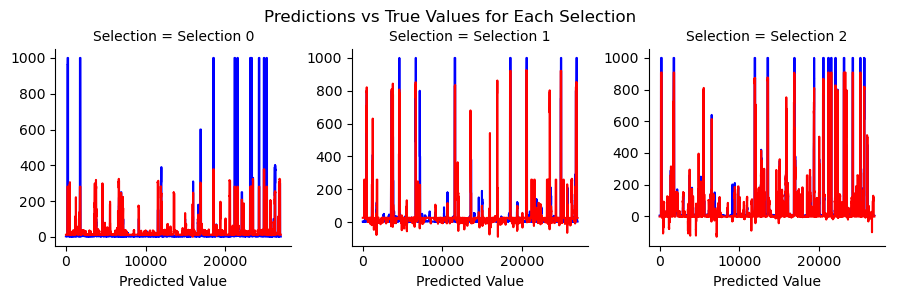

In [20]:
plot_predictions(y_val_tensor, predictions)


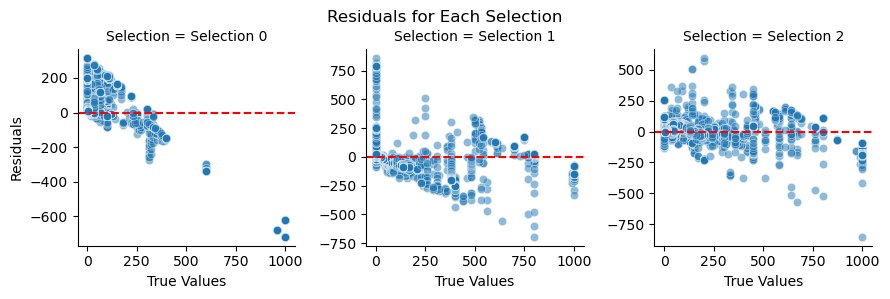

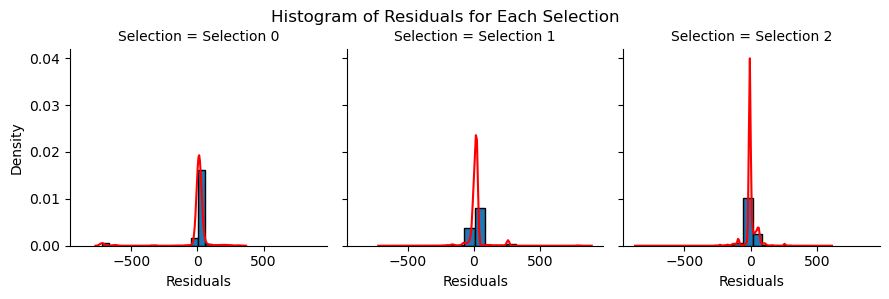

In [21]:
plot_residuals(y_val_tensor.numpy(), predictions)
plot_residual_histogram(y_val_tensor.numpy(), predictions)